In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.getcwd() + '\data'
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

c:\github\Simple_AI\data


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
c:\github\Simple_AI\data\chest_xray\data\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
c:\github\Simple_AI\data\chest_xray\data\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
'''
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)'''

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

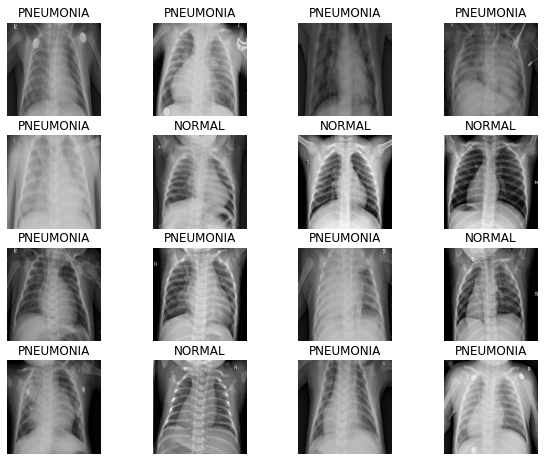

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
        #뒤에 둘중하나 꺼도됨
    ])
    
    return block

In [30]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        dense_block(4, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [31]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3851231123554643924,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5754978304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5348943201285772057
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [22]:
'''
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
'''

"\nwith tf.device('/GPU:0'):\n    history = model.fit(\n        train_ds,\n        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,\n        epochs=EPOCHS,\n        validation_data=val_ds,\n        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,\n        class_weight=class_weight,\n    )\n"

In [23]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
        #뒤에 둘중하나 꺼도됨
    ])
    
    return block

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=15,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 49s 153ms/step - loss: 0.3994 - accuracy: 0.8091 - precision: 0.9591 - recall: 0.7766 - val_loss: 0.6684 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 41s 156ms/step - loss: 0.2354 - accuracy: 0.9045 - precision: 0.9708 - recall: 0.8985 - val_loss: 1.0678 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 37s 142ms/step - loss: 0.2147 - accuracy: 0.9159 - precision: 0.9729 - recall: 0.9126 - val_loss: 0.1726 - val_accuracy: 0.9442 - val_precision: 0.9876 - val_recall: 0.9360
Epoch 4/15
261/261 [==============================] - 41s 156ms/step - loss: 0.1910 - accuracy: 0.9227 - precision: 0.9793 - recall: 0.9152 - val_loss: 0.1079 - val_accuracy: 0.9596 - val_precision: 0.9879 - val_recall: 0.9569
Epoch 5/15
261/261 [==============================] - 41s 156ms/step - loss: 0.1777 - accura

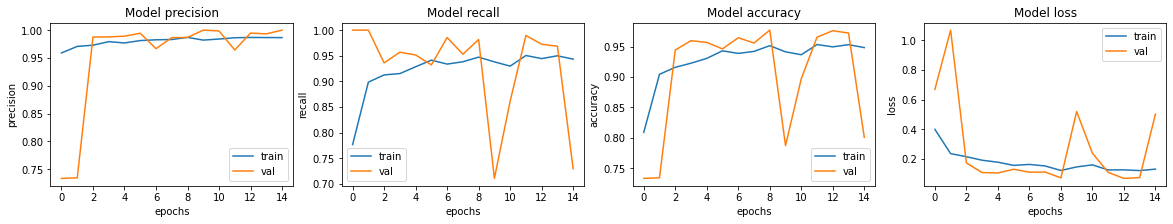

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 85ms/step - loss: 0.3953 - accuracy: 0.8494 - precision: 0.9512 - recall: 0.8000
Loss: 0.3953301012516022,
Accuracy: 0.8493589758872986,
Precision: 0.9512194991111755,
Recall: 0.800000011920929


In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=15,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 42s 143ms/step - loss: 0.1089 - accuracy: 0.9591 - precision: 0.9887 - recall: 0.9559 - val_loss: 0.2390 - val_accuracy: 0.9010 - val_precision: 1.0000 - val_recall: 0.8652
Epoch 2/15
261/261 [==============================] - 41s 156ms/step - loss: 0.1200 - accuracy: 0.9550 - precision: 0.9896 - recall: 0.9495 - val_loss: 0.0837 - val_accuracy: 0.9740 - val_precision: 0.9843 - val_recall: 0.9804
Epoch 3/15
261/261 [==============================] - 37s 141ms/step - loss: 0.1103 - accuracy: 0.9624 - precision: 0.9897 - recall: 0.9594 - val_loss: 0.1061 - val_accuracy: 0.9548 - val_precision: 0.9986 - val_recall: 0.9400
Epoch 4/15
261/261 [==============================] - 36s 139ms/step - loss: 0.1095 - accuracy: 0.9605 - precision: 0.9910 - recall: 0.9556 - val_loss: 0.1792 - val_accuracy: 0.9385 - val_precision: 0.9343 - val_recall: 0.9856
Epoch 5/15
261/261 [==============================] - 36s 139ms/step - loss: 0.1172 - accura

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
# 리콜이 0.99 정확도를 나타냄.

39/39 [==============================] - 3s 83ms/step - loss: 0.8169 - accuracy: 0.8109 - precision: 0.7709 - recall: 0.9923
Loss: 0.8169080018997192,
Accuracy: 0.8108974099159241,
Precision: 0.7709163427352905,
Recall: 0.9923076629638672


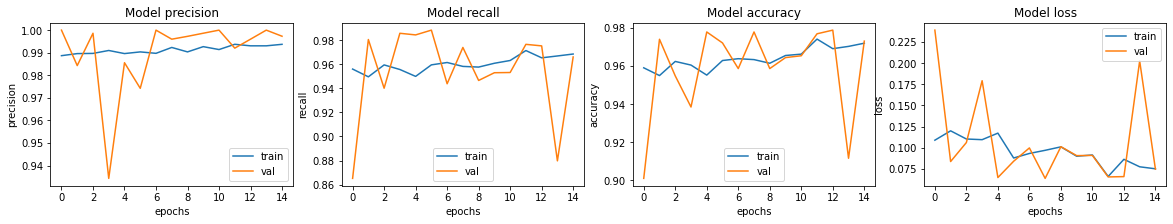

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 46s 159ms/step - loss: 0.1998 - accuracy: 0.9250 - precision: 0.9758 - recall: 0.9221 - val_loss: 0.1045 - val_accuracy: 0.9625 - val_precision: 0.9715 - val_recall: 0.9778
Epoch 2/5
261/261 [==============================] - 43s 165ms/step - loss: 0.2268 - accuracy: 0.9157 - precision: 0.9709 - recall: 0.9140 - val_loss: 0.2884 - val_accuracy: 0.8827 - val_precision: 1.0000 - val_recall: 0.8409
Epoch 3/5
261/261 [==============================] - 43s 166ms/step - loss: 0.2178 - accuracy: 0.9277 - precision: 0.9769 - recall: 0.9246 - val_loss: 0.2118 - val_accuracy: 0.9212 - val_precision: 1.0000 - val_recall: 0.8931
Epoch 4/5
261/261 [==============================] - 39s 149ms/step - loss: 0.2170 - accuracy: 0.9234 - precision: 0.9754 - recall: 0.9202 - val_loss: 0.1968 - val_accuracy: 0.9202 - val_precision: 1.0000 - val_recall: 0.8914
Epoch 5/5
261/261 [==============================] - 38s 147ms/step - loss: 0.1985 - accuracy: 0

39/39 [==============================] - 3s 84ms/step - loss: 0.4091 - accuracy: 0.8429 - precision: 0.8493 - recall: 0.9103
Loss: 0.40908628702163696,
Accuracy: 0.8429487347602844,
Precision: 0.8492823243141174,
Recall: 0.9102563858032227


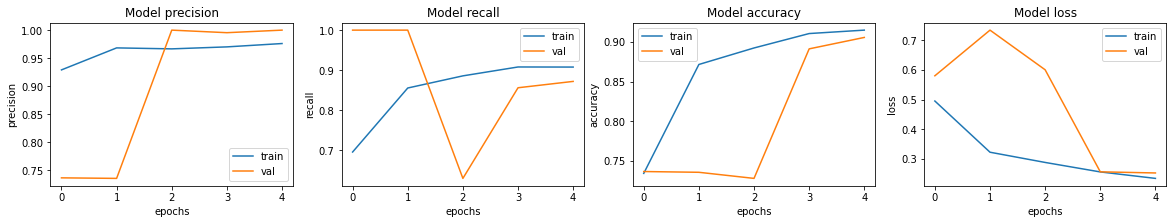

In [33]:

#컨벌루션을 더 깊게 만듬.

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

39/39 [==============================] - 3s 81ms/step - loss: 0.3794 - accuracy: 0.8574 - precision: 0.8644 - recall: 0.9154
Loss: 0.3794291019439697,
Accuracy: 0.8573718070983887,
Precision: 0.8644067645072937,
Recall: 0.9153845906257629


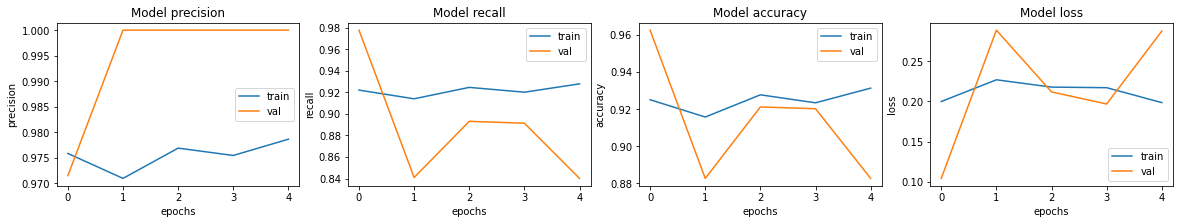

In [35]:
#컨벌루션을 더 깊게 만듬.
#에포크 2회차

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])